In [33]:
import pandas as pd
from sklearn import feature_selection, metrics
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb

# Train model on K562

In [34]:
K562_enh_df = pd.read_csv("../K562_crispri/enh_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
K562_pro_df = pd.read_csv("../K562_crispri/pro_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
K562_ABC_rep_df = pd.read_csv("../K562_crispri/EPCrisprBenchmark_ensemble_data_GRCh38.K562_ActivityOnly_features_NAfilled.tsv", sep="\t")

In [35]:
K562_all_df = pd.concat([K562_ABC_rep_df[['chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS', 'startTSS', 'endTSS', 'ABC.Score', 'distanceToTSS', 'Regulated']],
                    K562_enh_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "enh_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0), 
                    K562_pro_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "pro_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0),
                    ], axis = 1)
K562_all_df = K562_all_df[
    ['chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS',
       'startTSS', 'endTSS', 'enh_DNase.counts.RPKM',
       'enh_H3K4me3.counts.RPKM', 'enh_CTCF.counts.RPKM',
       'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM', 'pro_H3K4me3.counts.RPKM',
       'pro_CTCF.counts.RPKM', 'pro_H3K27ac.counts.RPKM', 'ABC.Score', 'distanceToTSS', 'Regulated',
    ]
]

In [36]:
K562_all_df.isna().any()

chrom                      False
chromStart                 False
chromEnd                   False
name                       False
chrTSS                     False
startTSS                   False
endTSS                     False
enh_DNase.counts.RPKM      False
enh_H3K4me3.counts.RPKM    False
enh_CTCF.counts.RPKM       False
enh_H3K27ac.counts.RPKM    False
pro_DNase.counts.RPKM      False
pro_H3K4me3.counts.RPKM    False
pro_CTCF.counts.RPKM       False
pro_H3K27ac.counts.RPKM    False
ABC.Score                  False
distanceToTSS              False
Regulated                  False
dtype: bool

## Verify model works as intended 
We make a slight change to K562_crispri/main.ipynb. Here we standardise the bam counts. 
Use chr1 and chr11 to test. Verify model works as before.

In [37]:
# Mutual Information
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'ABC.Score',
       'distanceToTSS']
label_column = "Regulated"

print(feature_columns)

feature_MI = feature_selection.mutual_info_classif(K562_all_df[feature_columns], K562_all_df[label_column])

MI_results = list(zip(feature_columns, feature_MI))
MI_results.sort(key = lambda x: x[1], reverse=True)
print(MI_results)

['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM', 'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM', 'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM', 'pro_H3K27ac.counts.RPKM', 'ABC.Score', 'distanceToTSS']
[('ABC.Score', 0.087609454510581), ('distanceToTSS', 0.06574557387831192), ('enh_DNase.counts.RPKM', 0.026782633871187622), ('enh_H3K27ac.counts.RPKM', 0.02631376598981472), ('pro_DNase.counts.RPKM', 0.022796289263419922), ('pro_H3K4me3.counts.RPKM', 0.019993333901604515), ('pro_H3K27ac.counts.RPKM', 0.01709233820009337), ('enh_CTCF.counts.RPKM', 0.0133610887157396), ('enh_H3K4me3.counts.RPKM', 0.012510665603834958), ('pro_CTCF.counts.RPKM', 0.008230478426240584)]


In [38]:
def run_xgboost(feature_columns, chrom_test_set, all_df, plot_auprc=True, plot_xgb_feat_importance=True):
    X_train = all_df[~all_df["chrom"].isin(chrom_test_set)][feature_columns]
    y_train = all_df[~all_df["chrom"].isin(chrom_test_set)]["Regulated"]
    X_test = all_df[all_df["chrom"].isin(chrom_test_set)][feature_columns]
    y_test = all_df[all_df["chrom"].isin(chrom_test_set)]["Regulated"]

    clf = xgb.XGBClassifier()
    clf.fit(X_train, y_train)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    aupr = metrics.auc(recall, precision)

    print("AUPRC:", aupr)

    if plot_auprc:
        plt.title("Precision Recall Curve")
        plt.plot(recall, precision)
        plt.show()

    if plot_xgb_feat_importance:
        xgb.plot_importance(clf) # F score is simply the number of times the classifier split on a particular feature. 
        plt.show()

AUPRC: 0.694160358695172


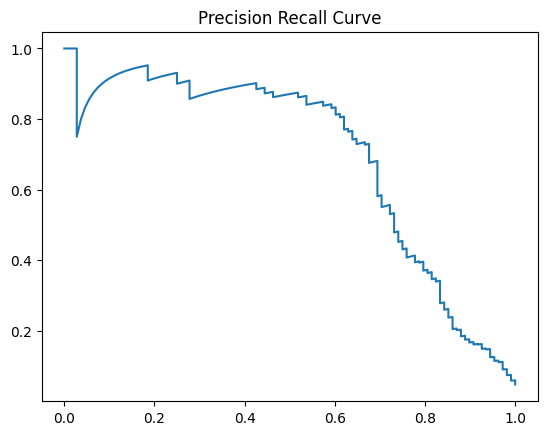

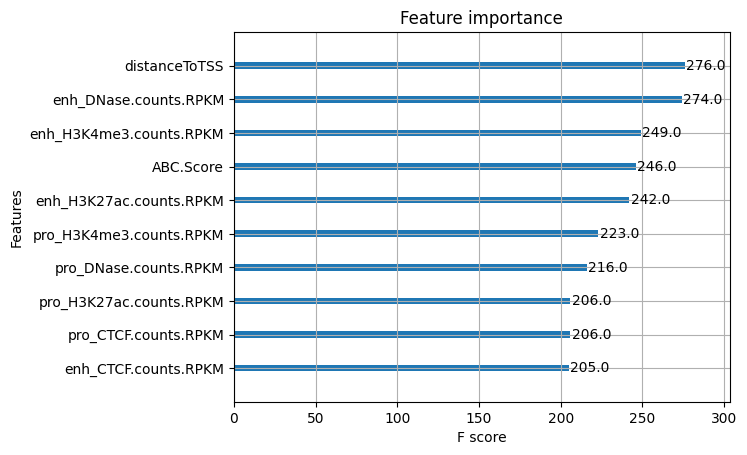

In [40]:
# XgBoost Performance

feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'ABC.Score',
       'distanceToTSS']
chrom_test_set = ["chr1", "chr11"]

run_xgboost(feature_columns, chrom_test_set, K562_all_df)

## Train Model on all chromosomes

In [42]:
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'ABC.Score',
       'distanceToTSS']

X_train = K562_all_df[feature_columns]
y_train = K562_all_df["Regulated"]

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Evaluate Model Generalisability using LNCaP set

In [43]:
LNCaP_enh_df = pd.read_csv("enh_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
LNCaP_pro_df = pd.read_csv("pro_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
LNCaP_ABC_rep_df = pd.read_csv("ABC_annotated_candidate_pairs.tsv", sep="\t")

LNCaP_all_df = pd.concat([LNCaP_ABC_rep_df[['chr', 'start', 'end', 'chrTSS', 'startTSS', 'endTSS', 'ABC.Score', 'distanceToTSS', 'Label']],
                    LNCaP_enh_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "enh_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0), 
                    LNCaP_pro_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "pro_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0),
                    ], axis = 1)
LNCaP_all_df = LNCaP_all_df[
    ['chr', 'start', 'end', 'chrTSS',
       'startTSS', 'endTSS', 'enh_DNase.counts.RPKM',
       'enh_H3K4me3.counts.RPKM', 'enh_CTCF.counts.RPKM',
       'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM', 'pro_H3K4me3.counts.RPKM',
       'pro_CTCF.counts.RPKM', 'pro_H3K27ac.counts.RPKM', 'ABC.Score', 'distanceToTSS', 'Label',
    ]
]

In [44]:
LNCaP_all_df

,chr,start,end,chrTSS,startTSS,endTSS,enh_DNase.counts.RPKM,enh_H3K4me3.counts.RPKM,enh_CTCF.counts.RPKM,enh_H3K27ac.counts.RPKM,pro_DNase.counts.RPKM,pro_H3K4me3.counts.RPKM,pro_CTCF.counts.RPKM,pro_H3K27ac.counts.RPKM,ABC.Score,distanceToTSS,Label
0,chr1,927735,928235,chr1,1074057,1074557,-0.051598,-0.384053,-0.218447,-0.431786,0.356251,-0.630798,-0.326640,0.053671,0.000612,146322,True
1,chr1,1308973,1309940,chr1,1280185,1280685,0.242316,-0.313453,-0.250202,0.697479,0.356251,-0.630798,-0.326640,0.053671,0.027737,29021,True
2,chr1,1325428,1325928,chr1,1348862,1349362,1.573270,0.158372,-0.356438,0.566639,0.356251,-0.630798,-0.326640,0.053671,0.009468,23434,True
3,chr1,1456798,1457298,chr1,1449438,1449938,0.015939,5.259328,-0.316167,-0.170997,0.356251,-0.630798,-0.326640,0.053671,0.000000,7360,True
4,chr1,1574601,1575132,chr1,1574632,1575132,0.246691,-0.251106,-0.381313,0.122390,0.356251,-0.630798,-0.326640,0.053671,1.000000,16,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162158,chrY,12663123,12663623,chrY,12904535,12905035,-0.304862,0.839194,-0.381313,0.790661,-0.401711,-0.092440,-0.406852,-0.114230,0.000000,241412,False
162159,chrY,12904535,12905385,chrY,13480420,13480920,-0.231365,1.430520,-0.413886,0.452211,-0.633989,-0.912815,-0.406852,-0.695427,0.000000,575710,False
162160,chrY,13435895,13436395,chrY,13703316,13703816,-0.383655,0.205984,-0.316167,0.171288,-0.563083,-0.907109,-0.246428,-0.656681,0.000000,267421,False
162161,chrY,19077297,19077797,chrY,19744689,19745189,-0.591894,-0.390906,-0.348740,-0.480684,-0.550858,-0.343891,-0.366746,0.105333,0.000000,667392,False


AUPRC: 0.5289971450263138


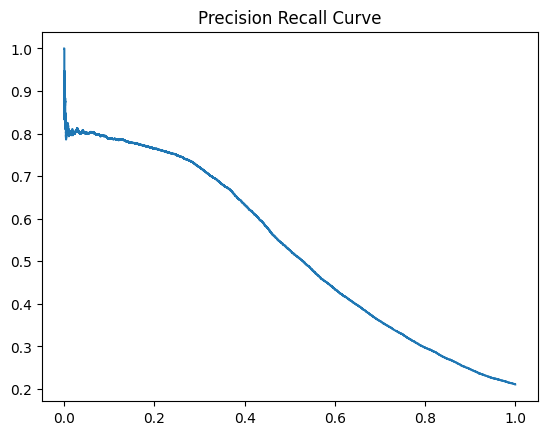

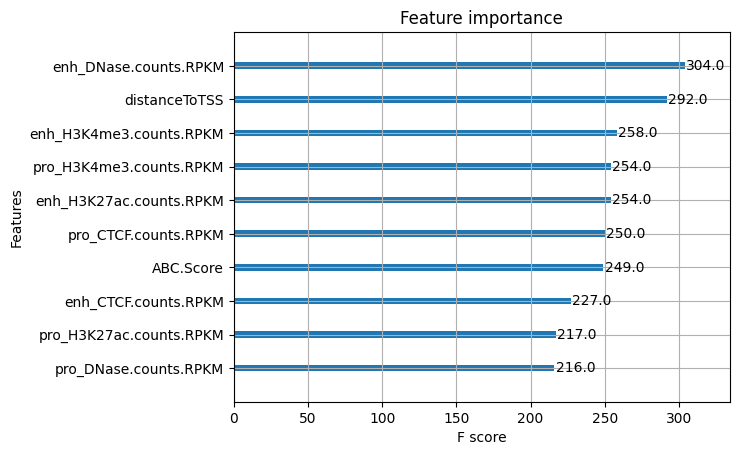

In [47]:
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'ABC.Score',
       'distanceToTSS']

X_test = LNCaP_all_df[feature_columns]
y_test = LNCaP_all_df["Label"]

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print("AUPRC:", aupr)

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()


xgb.plot_importance(clf) # F score is simply the number of times the classifier split on a particular feature. 
plt.show()